In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load historical portfolio value
portfolio = pd.read_csv("../outputs/results/high_growth_portfolio_value.csv", index_col=0, parse_dates=True).squeeze()
portfolio = portfolio.dropna()


C:\Users\chris\AppData\Local\Temp\ipykernel_27416\3223230343.py:49: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


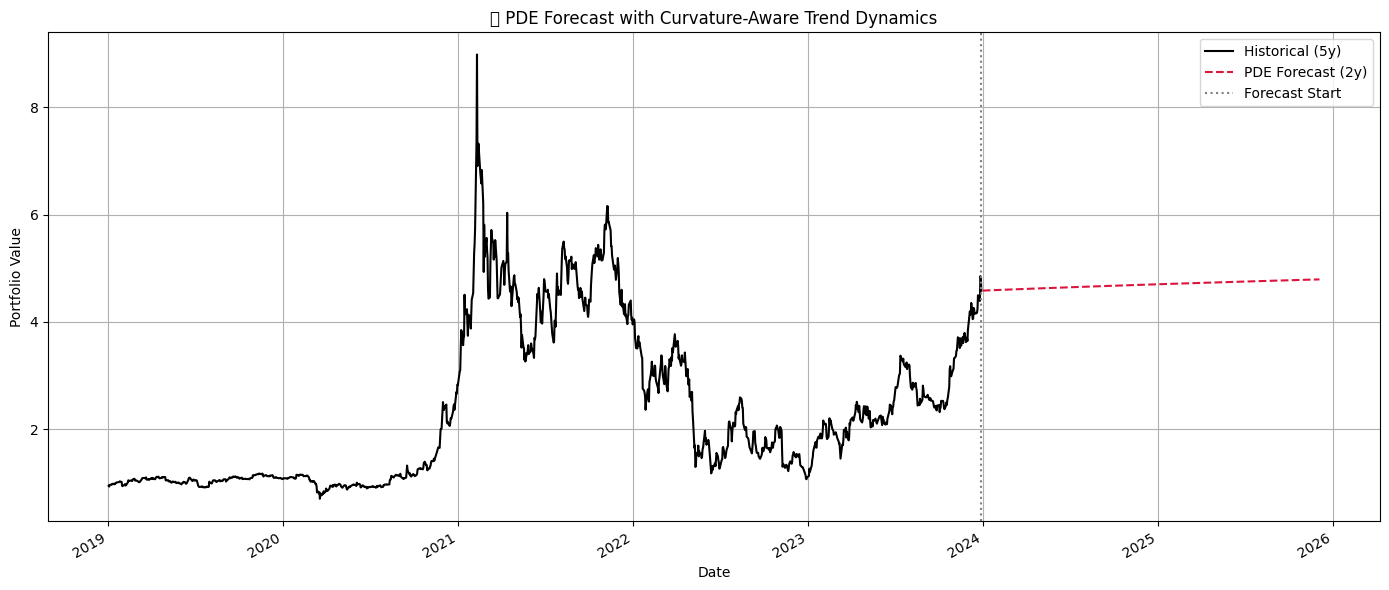

In [9]:
# === Geometric PDE Forecast with Curvature Trend Boost ===
def pde_forecast_with_curvature_trend(series, days=504, D=0.005, alpha=0.002):
    u = series.values.copy().reshape(1, -1)
    N = u.shape[1]
    timesteps = days

    # Finite difference Laplacian (∇²) — curvature
    laplacian = np.zeros((N, N))
    for i in range(1, N - 1):
        laplacian[i, i - 1] = 1
        laplacian[i, i] = -2
        laplacian[i, i + 1] = 1
    laplacian[0, 0] = laplacian[-1, -1] = -1
    laplacian /= (N**2)  # scale by domain size

    dt = 1.0
    forecast_matrix = [u.flatten()]

    for t in range(timesteps):
        grad = np.gradient(u.flatten())                     # ∇u = velocity
        trend_term = alpha * np.abs(grad).reshape(1, -1)    # geometric bias
        du = D * laplacian @ u.T + trend_term.T             # PDE step
        u = u + du.T * dt
        u = np.clip(u, a_min=0, a_max=None)
        forecast_matrix.append(u.flatten())

    forecast_matrix = np.array(forecast_matrix)
    forecast_vals = forecast_matrix[1:, -1]  # future values only
    future_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=days, freq='B')
    return pd.Series(forecast_vals, index=future_index)

# === Load historical portfolio value ===
portfolio = pd.read_csv("../outputs/results/high_growth_portfolio_value.csv", index_col=0, parse_dates=True).squeeze()
portfolio = portfolio.dropna()

# === Run forecast
holt_forecast = pde_forecast_with_curvature_trend(portfolio, days=504, D=0.005, alpha=0.002)

# === Plot result
plt.figure(figsize=(14, 6))
portfolio.plot(label="Historical (5y)", color="black")
holt_forecast.plot(label="PDE Forecast (2y)", linestyle="--", color="crimson")
plt.axvline(x=portfolio.index[-1], color='gray', linestyle=':', label="Forecast Start")
plt.title("🌡️ PDE Forecast with Curvature-Aware Trend Dynamics")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\chris\AppData\Local\Temp\ipykernel_27416\2770734754.py:25: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


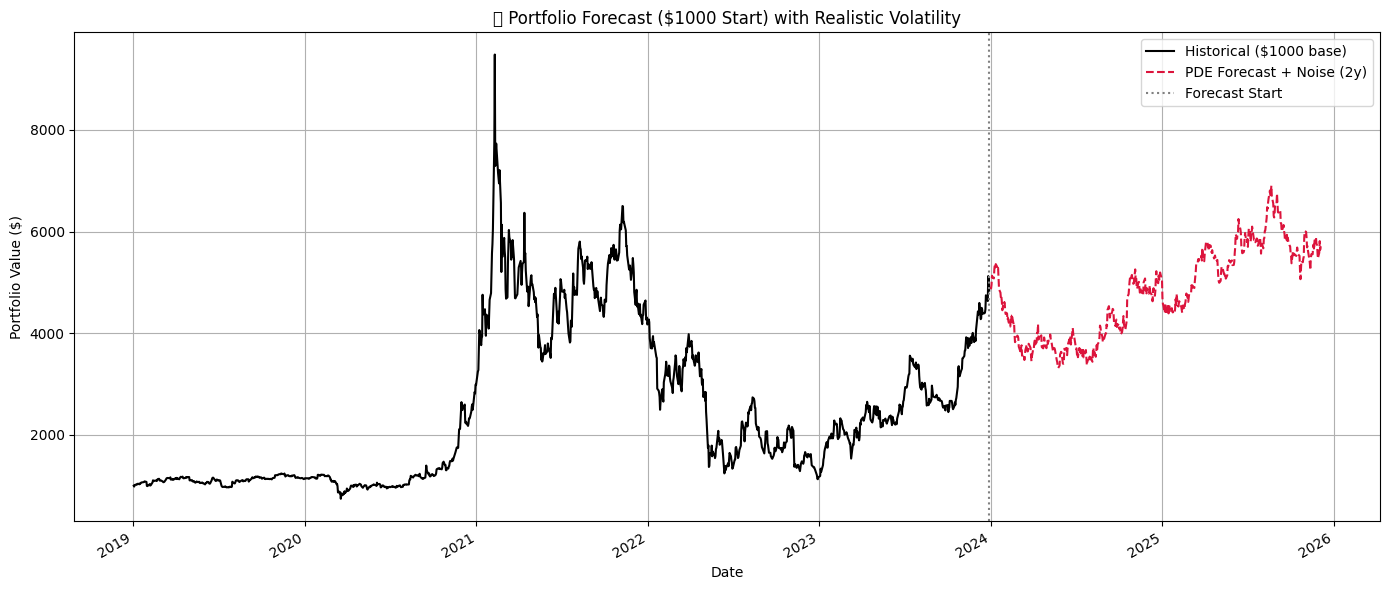

In [10]:
# === Rescale portfolio and forecast to start at $1,000
portfolio_scaled = 1000 * portfolio / portfolio.iloc[0]
forecast_scaled = 1000 * holt_forecast / portfolio.iloc[0]

# === Estimate historical volatility
daily_returns = portfolio_scaled.pct_change().dropna()
volatility = daily_returns.std()

# === Add geometric noise to forecast (simulate market randomness)
np.random.seed(42)
noise = np.random.normal(loc=0, scale=volatility, size=len(forecast_scaled))
noise = np.cumsum(noise)  # accumulate over time
forecast_noisy = forecast_scaled * (1 + noise * 0.5)  # volatility factor

# === Plot updated graph
plt.figure(figsize=(14, 6))
portfolio_scaled.plot(label="Historical ($1000 base)", color="black")
forecast_noisy.plot(label="PDE Forecast + Noise (2y)", linestyle="--", color="crimson")
plt.axvline(x=portfolio.index[-1], color='gray', linestyle=':', label="Forecast Start")
plt.title("💸 Portfolio Forecast ($1000 Start) with Realistic Volatility")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\chris\AppData\Local\Temp\ipykernel_27416\3246751503.py:59: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(forecast_index, mean_path, label="Realistic Forecast (w/ Compound DCA)", color="darkgreen")
C:\Users\chris\AppData\Local\Temp\ipykernel_27416\3246751503.py:67: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


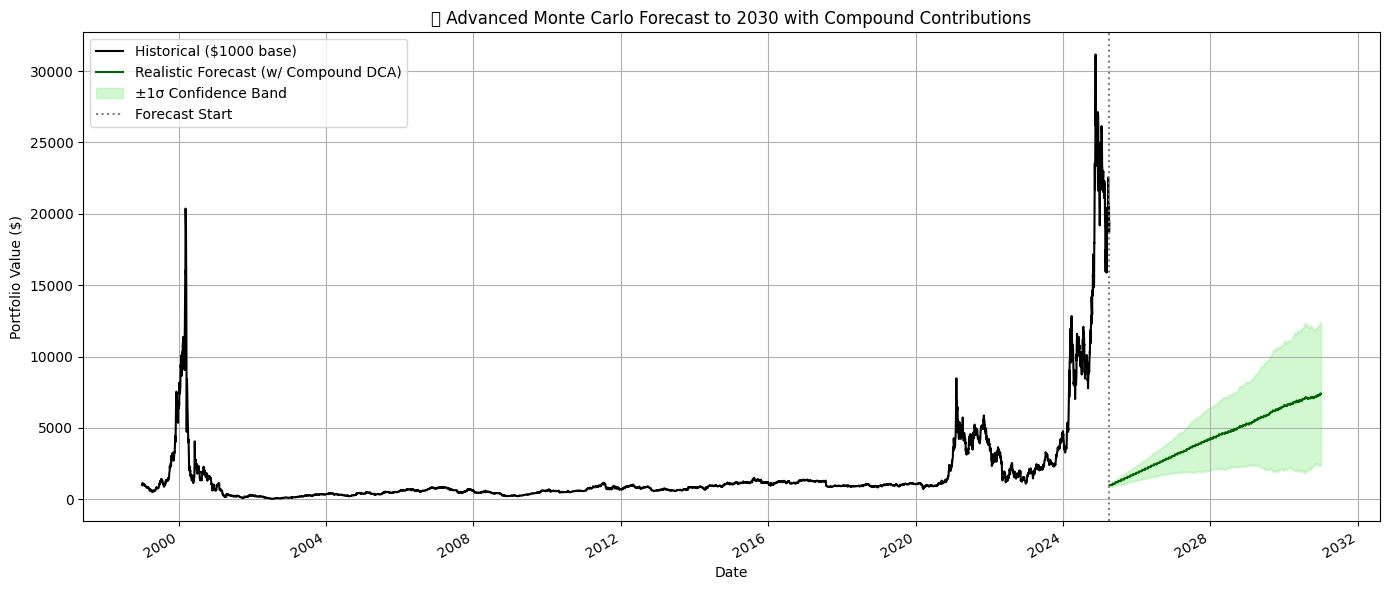

C:\Users\chris\AppData\Local\Temp\ipykernel_27416\3246751503.py:86: UserWarning: Glyph 127909 (\N{MOVIE CAMERA}) missing from font(s) DejaVu Sans.
  ani = FuncAnimation(fig, update, frames=len(forecast_index), interval=10, blit=True)
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127909 (\N{MOVIE CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


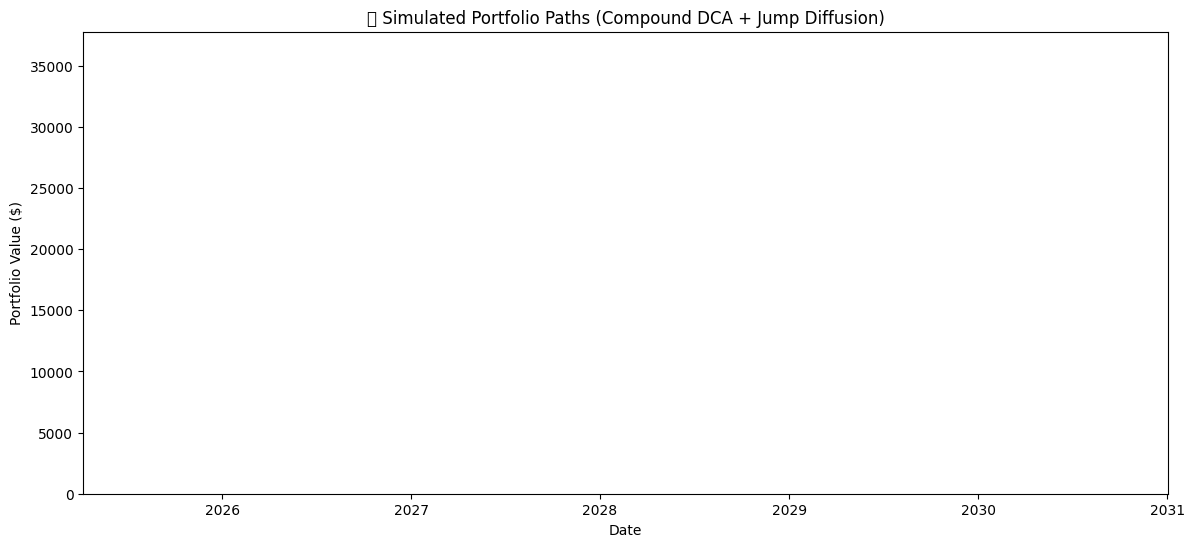

In [16]:
# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 📊 Load and Scale Historical Data
portfolio = pd.read_csv("../outputs/results/high_growth_portfolio_value.csv", index_col=0, parse_dates=True).squeeze().dropna()
portfolio_scaled = 1000 * portfolio / portfolio.iloc[0]

# ⚙️ Simulation Parameters
initial_investment = 1000
monthly_contribution = 100
contribution_interval = 21  # ~business days per month
days = 1500  # ~6 years into 2030
simulations = 500
np.random.seed(42)

# 📈 Realistic Estimated Market Parameters
mu = 0.0008       # daily average return ~20% annualized
sigma = 0.025     # daily std ~40% annualized volatility
lambda_jump = 0.01    # ~2 jumps per year
mu_jump = -0.08       # average jump -8%
sigma_jump = 0.04     # jump volatility

# 🧮 Simulate Compound-Growth Contributions (Advanced DCA)
paths = np.full((days, simulations), initial_investment, dtype=np.float64)

for sim in range(simulations):
    for t in range(1, days):
        rand = np.random.normal(0, 1)
        diffusion = (mu - 0.5 * sigma**2) + sigma * rand
        jump = np.random.poisson(lambda_jump)
        jump_term = jump * (mu_jump + sigma_jump * np.random.normal(0, 1))
        growth = np.exp(diffusion + jump_term)

        # Grow existing value
        paths[t, sim] = paths[t - 1, sim] * growth

        # Add new contribution that also compounds
        if t % contribution_interval == 0:
            compounding_steps = days - t
            future_growth = np.cumprod(np.exp(
                (mu - 0.5 * sigma**2) + sigma * np.random.normal(0, 1, compounding_steps) +
                np.random.poisson(lambda_jump, compounding_steps) * (mu_jump + sigma_jump * np.random.normal(0, 1, compounding_steps))
            ))
            paths[t:, sim] += monthly_contribution * future_growth

# 📊 Forecast Stats
forecast_index = pd.date_range(start=portfolio.index[-1] + pd.Timedelta(days=1), periods=days, freq='B')
mean_path = paths.mean(axis=1)
std_path = paths.std(axis=1)
upper_band = mean_path + std_path
lower_band = mean_path - std_path

# 📈 Static Plot
plt.figure(figsize=(14, 6))
portfolio_scaled.plot(label="Historical ($1000 base)", color="black")
plt.plot(forecast_index, mean_path, label="Realistic Forecast (w/ Compound DCA)", color="darkgreen")
plt.fill_between(forecast_index, lower_band, upper_band, color="lightgreen", alpha=0.4, label="±1σ Confidence Band")
plt.axvline(x=portfolio.index[-1], color='gray', linestyle=':', label="Forecast Start")
plt.title("📈 Advanced Monte Carlo Forecast to 2030 with Compound Contributions")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 🎞️ Animation of Sample Paths
sample_paths = paths[:, :25]  # select 25 random paths
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlim(forecast_index[0], forecast_index[-1])
ax.set_ylim(0, np.max(sample_paths) * 1.1)
ax.set_title("🎥 Simulated Portfolio Paths (Compound DCA + Jump Diffusion)")
ax.set_xlabel("Date")
ax.set_ylabel("Portfolio Value ($)")
lines = [ax.plot([], [], lw=1, alpha=0.6)[0] for _ in range(sample_paths.shape[1])]

# Frame Update Logic
def update(frame):
    for i, line in enumerate(lines):
        line.set_data(forecast_index[:frame], sample_paths[:frame, i])
    return lines

ani = FuncAnimation(fig, update, frames=len(forecast_index), interval=10, blit=True)
plt.show()


[*********************100%***********************]  14 of 14 completed



📈 Optimal Portfolio Allocation (Stable, 20-Year Horizon, ≤5% Weekly Risk, ≥50% ETFs, ≥1% Each Asset):
SCHD     0.2500
BRK-B    0.2500
SWPPX    0.2300
MSTR     0.1150
PLTR     0.0452
UNH      0.0298
GOOG     0.0100
MSFT     0.0100
JPM      0.0100
QQQM     0.0100
MRK      0.0100
LULU     0.0100
SCHG     0.0100
SOFI     0.0100
dtype: float64


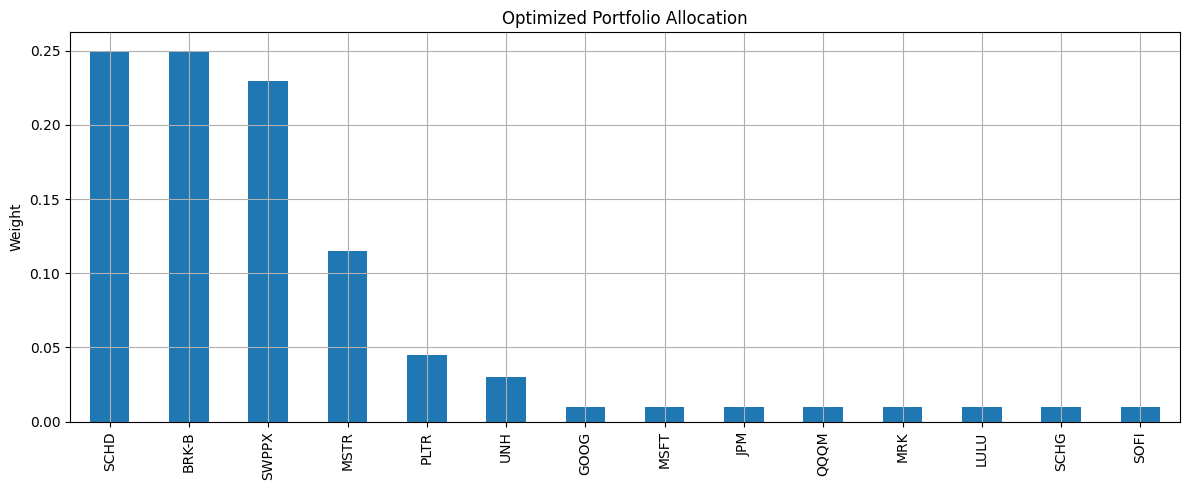

C:\Users\chris\AppData\Local\Temp\ipykernel_27416\3140302899.py:90: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


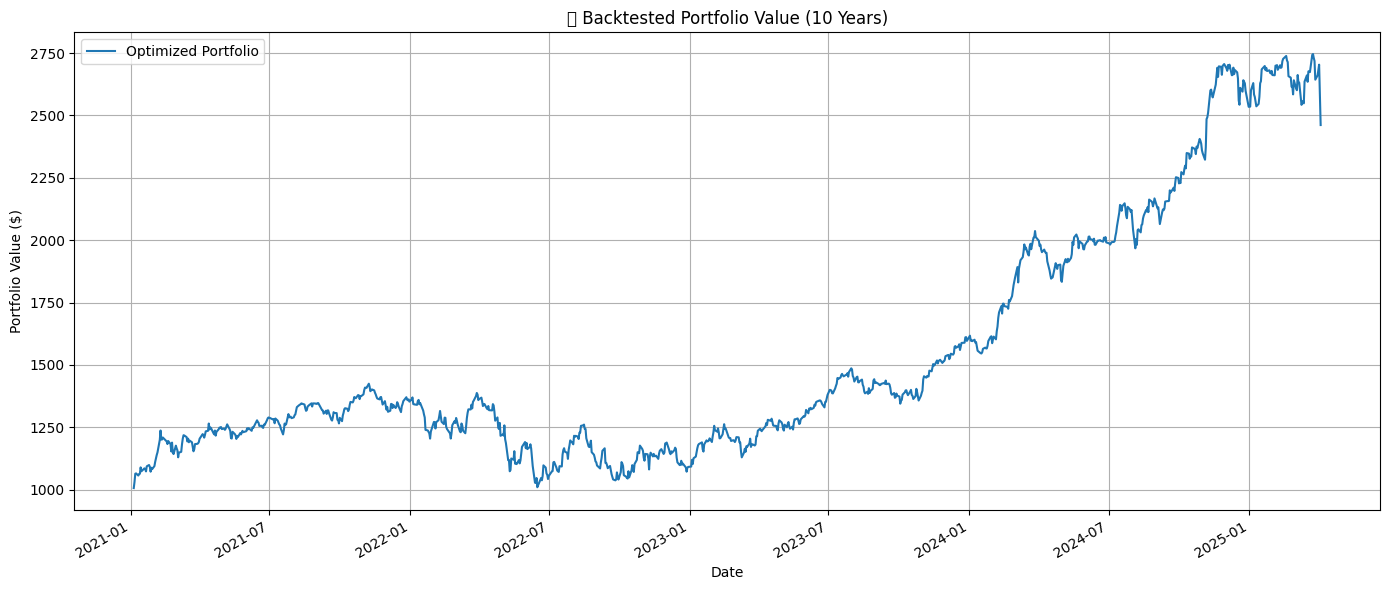

C:\Users\chris\AppData\Local\Temp\ipykernel_27416\3140302899.py:105: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


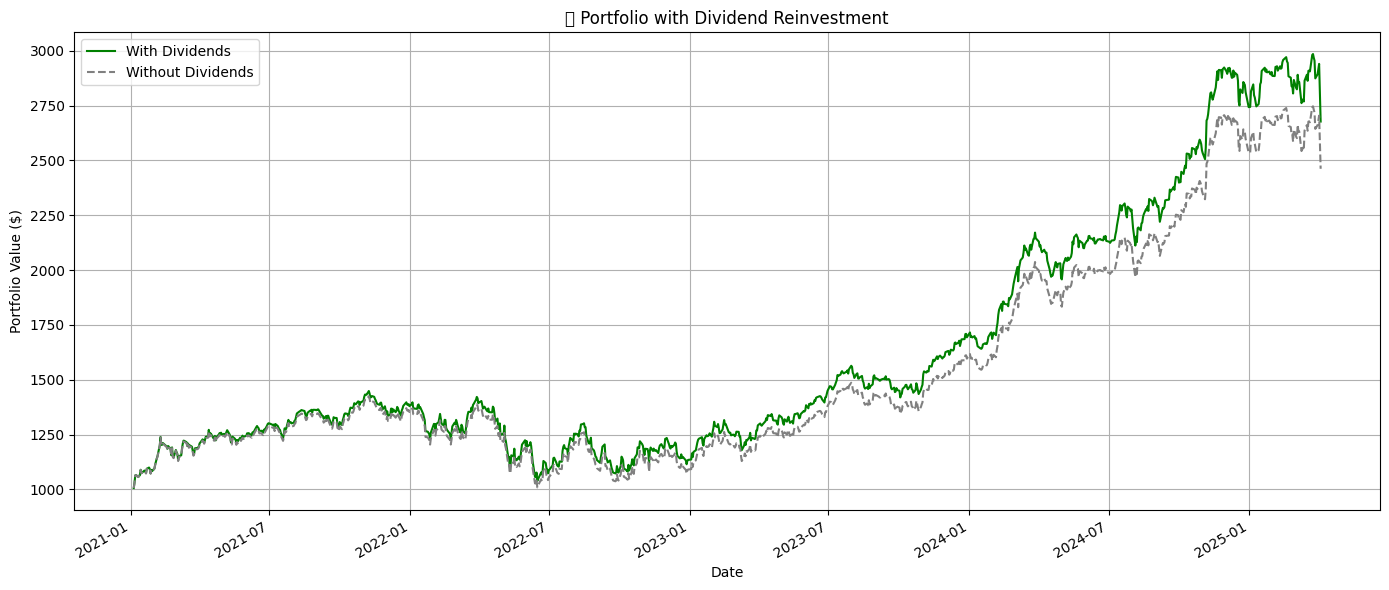

C:\Users\chris\AppData\Local\Temp\ipykernel_27416\3140302899.py:132: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


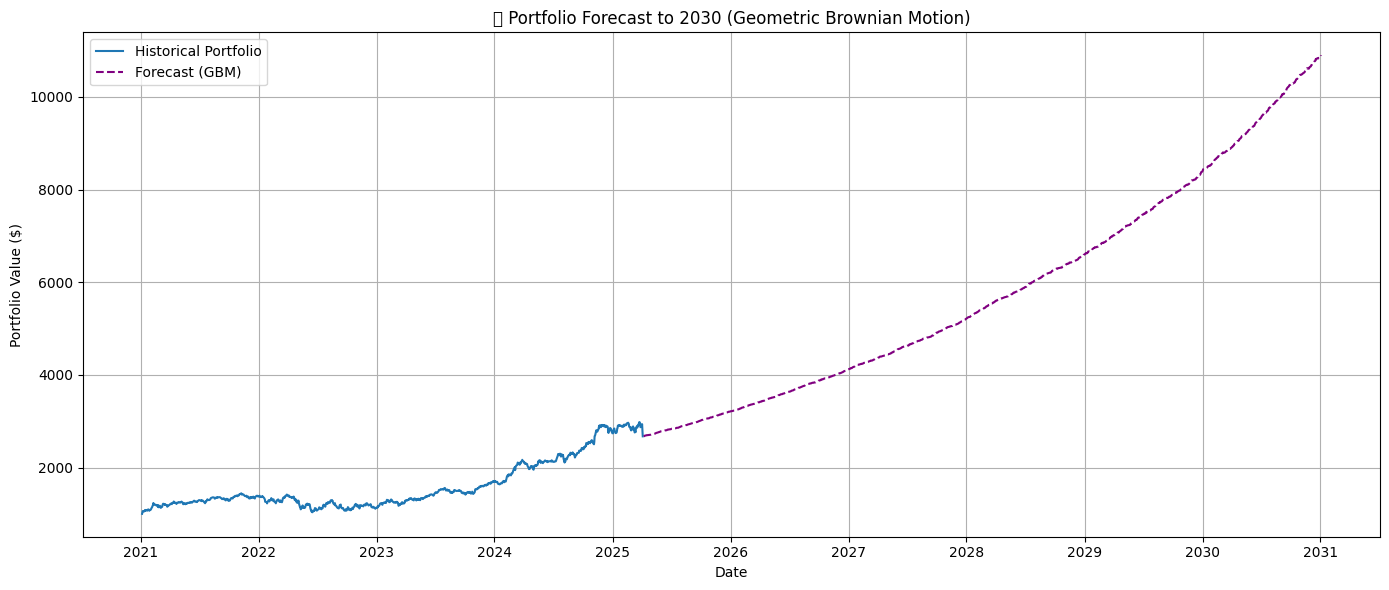

In [21]:
# 📦 Imports
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 🎯 Target Risk Constraint: Max 5% weekly loss
def max_weekly_drawdown_constraint(weights, returns, confidence_level=0.99):
    weekly_returns = returns.resample('W').sum()
    portfolio_returns = weekly_returns @ weights
    var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    return abs(var) - 0.05

# 🔧 Settings
tickers = ["SCHD", "SWPPX", "SCHG", "QQQM",
           "PLTR", "MSTR", "SOFI", "MSFT", "BRK-B",
           "GOOG", "JPM", "MRK", "LULU", "UNH"]

# ⏳ Download Data
data = yf.download(tickers, start="2014-01-01", end="2025-04-07", group_by='ticker', auto_adjust=True)

# 🧮 Clean Adjusted Close
df = pd.DataFrame()
for ticker in tickers:
    try:
        df[ticker] = data[ticker]['Close']
    except:
        pass
returns = df.pct_change().dropna()

# 🔧 Optimization Functions
def portfolio_return(weights):
    return np.sum(returns.mean() * weights) * 252

def portfolio_volatility(weights):
    return np.sqrt(weights.T @ returns.cov() @ weights) * np.sqrt(252)

def sharpe_ratio(weights):
    return -portfolio_return(weights) / portfolio_volatility(weights)

# 🔒 Constraints & Bounds
num_assets = len(returns.columns)
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
    {'type': 'ineq', 'fun': lambda x: max_weekly_drawdown_constraint(x, returns)}
]

# ✅ Add ETF Constraint: 50% minimum in ETFs
etf_names = ["SCHD", "SWPPX", "SCHG", "QQQM"]
etf_indices = [returns.columns.get_loc(etf) for etf in etf_names if etf in returns.columns]

def etf_weight_constraint(weights):
    return np.sum([weights[i] for i in etf_indices]) - 0.5

constraints.append({'type': 'ineq', 'fun': etf_weight_constraint})

# ✅ Add minimum 1% constraint for each asset
bounds = tuple((0.01, 0.25) for _ in range(num_assets))  # between 1% and 25%
init_guess = np.ones(num_assets) / num_assets

# 🚀 Run Optimization
opt = minimize(sharpe_ratio, init_guess,
               method='SLSQP', bounds=bounds, constraints=constraints)

# ✅ Output Results
opt_weights = pd.Series(opt.x, index=returns.columns)
opt_weights = opt_weights[opt_weights > 0.001].sort_values(ascending=False)
print("\n📈 Optimal Portfolio Allocation (Stable, 20-Year Horizon, ≤5% Weekly Risk, ≥50% ETFs, ≥1% Each Asset):")
print(opt_weights.round(4))

# 📊 Plot Weights
opt_weights.plot(kind='bar', figsize=(12, 5), title="Optimized Portfolio Allocation")
plt.ylabel("Weight")
plt.tight_layout()
plt.grid(True)
plt.show()

# 🔁 Backtest: Portfolio Value Over Time
opt_weights = opt_weights.reindex(returns.columns).fillna(0)
portfolio_returns = (returns @ opt_weights).dropna()
initial_value = 1000
portfolio_value = (1 + portfolio_returns).cumprod() * initial_value

plt.figure(figsize=(14, 6))
portfolio_value.plot(title="🔁 Backtested Portfolio Value (10 Years)", label="Optimized Portfolio")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 💸 Estimate Dividends: Assume 2% yield reinvested daily
dividend_yield_annual = 0.02
dividend_rate_daily = (1 + dividend_yield_annual) ** (1/252) - 1
portfolio_value_with_dividends = portfolio_value * (1 + dividend_rate_daily) ** np.arange(len(portfolio_value))

plt.figure(figsize=(14, 6))
portfolio_value_with_dividends.plot(label="With Dividends", color="green")
portfolio_value.plot(label="Without Dividends", linestyle="--", color="gray")
plt.title("📈 Portfolio with Dividend Reinvestment")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔮 Forecast Future Performance Using GBM
mu = portfolio_returns.mean()
sigma = portfolio_returns.std()
days = 1500  # ~6 years
simulations = 500
np.random.seed(42)
paths = np.zeros((days, simulations))
paths[0] = portfolio_value_with_dividends.iloc[-1]

for t in range(1, days):
    rand = np.random.normal(0, 1, simulations)
    paths[t] = paths[t-1] * np.exp((mu - 0.5 * sigma**2) + sigma * rand)

forecast_index = pd.date_range(start=portfolio_value_with_dividends.index[-1] + pd.Timedelta(days=1), periods=days, freq='B')
mean_path = paths.mean(axis=1)

plt.figure(figsize=(14, 6))
plt.plot(portfolio_value_with_dividends, label="Historical Portfolio")
plt.plot(forecast_index, mean_path, label="Forecast (GBM)", linestyle="--", color="purple")
plt.title("🔮 Portfolio Forecast to 2030 (Geometric Brownian Motion)")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
